In [10]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import umap
from scipy.stats import ks_2samp
from sklearn.metrics.pairwise import pairwise_distances
import warnings
warnings.filterwarnings('ignore')

# Load datasets
real_df = pd.read_csv('../Enhanced_Kurigram_Dataset.csv')
synthetic_df = pd.read_csv('CTGAN_Synthetic_ANC_Visits.csv')

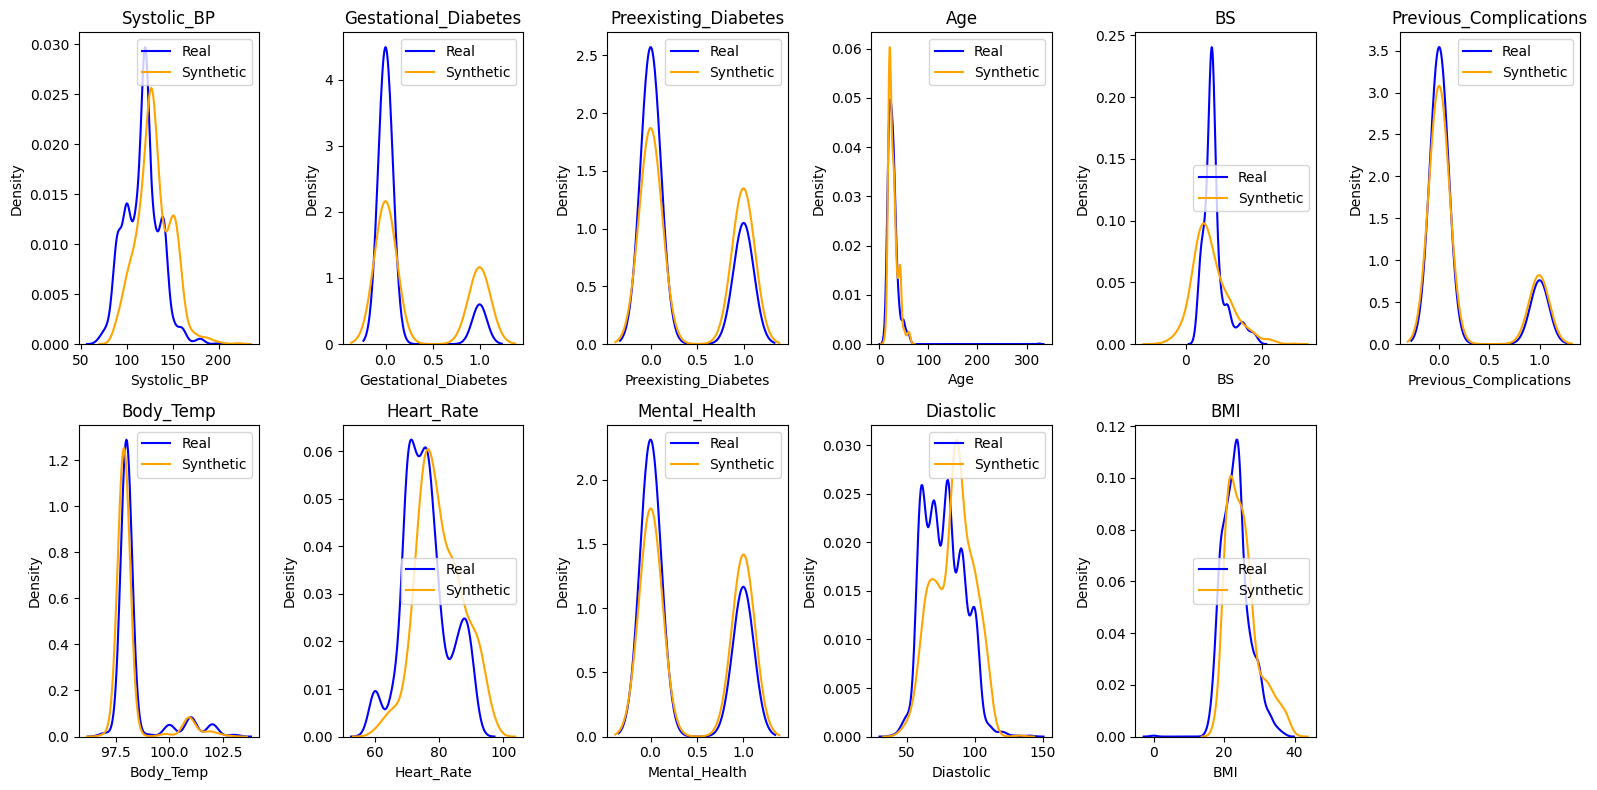

In [11]:
# KDE plots for distribution matching
numeric_cols_real = set(real_df.select_dtypes(include=np.number).columns)
numeric_cols_synth = set(synthetic_df.select_dtypes(include=np.number).columns)
common_numeric_cols = list(numeric_cols_real & numeric_cols_synth)

plt.figure(figsize=(16, 8))
for i, col in enumerate(common_numeric_cols):
    plt.subplot(2, (len(common_numeric_cols)+1)//2, i+1)
    sns.kdeplot(real_df[col], label='Real', color='blue')
    sns.kdeplot(synthetic_df[col], label='Synthetic', color='orange')
    plt.title(col)
    plt.legend()
plt.tight_layout()
plt.show()

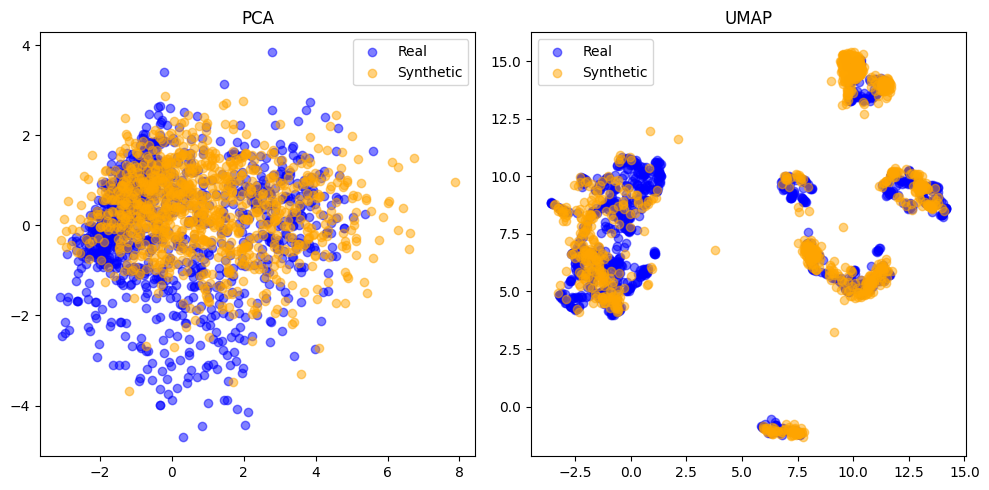

In [12]:
# PCA and UMAP visualization
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
real_scaled = scaler.fit_transform(real_df[common_numeric_cols])
synthetic_scaled = scaler.transform(synthetic_df[common_numeric_cols])

# PCA
pca = PCA(n_components=2)
real_pca = pca.fit_transform(real_scaled)
synthetic_pca = pca.transform(synthetic_scaled)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(real_pca[:,0], real_pca[:,1], alpha=0.5, label='Real', c='blue')
plt.scatter(synthetic_pca[:,0], synthetic_pca[:,1], alpha=0.5, label='Synthetic', c='orange')
plt.title('PCA')
plt.legend()

# UMAP
reducer = umap.UMAP(n_components=2, random_state=42)
real_umap = reducer.fit_transform(real_scaled)
synthetic_umap = reducer.transform(synthetic_scaled)
plt.subplot(1,2,2)
plt.scatter(real_umap[:,0], real_umap[:,1], alpha=0.5, label='Real', c='blue')
plt.scatter(synthetic_umap[:,0], synthetic_umap[:,1], alpha=0.5, label='Synthetic', c='orange')
plt.title('UMAP')
plt.legend()
plt.tight_layout()
plt.show()

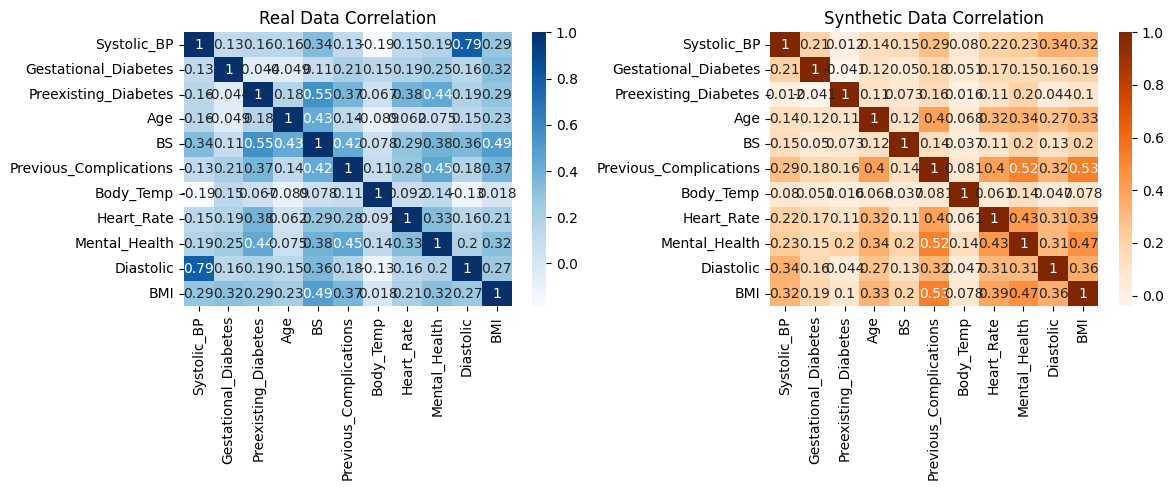

In [13]:
# Correlation matrix comparison
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.heatmap(real_df[common_numeric_cols].corr(), annot=True, cmap='Blues')
plt.title('Real Data Correlation')

plt.subplot(1,2,2)
sns.heatmap(synthetic_df[common_numeric_cols].corr(), annot=True, cmap='Oranges')
plt.title('Synthetic Data Correlation')
plt.tight_layout()
plt.show()

In [15]:
# MMD and KS test
def compute_mmd(X, Y, kernel='rbf', gamma=1.0):
    XX = pairwise_distances(X, X, metric='euclidean')
    YY = pairwise_distances(Y, Y, metric='euclidean')
    XY = pairwise_distances(X, Y, metric='euclidean')
    K_XX = np.exp(-gamma * XX ** 2)
    K_YY = np.exp(-gamma * YY ** 2)
    K_XY = np.exp(-gamma * XY ** 2)
    return K_XX.mean() + K_YY.mean() - 2 * K_XY.mean()

mmd_score = compute_mmd(real_scaled, synthetic_scaled)
print(f'MMD score (lower is better): {mmd_score:.4f}')

# KS test for each numeric column
ks_results = {}
for col in common_numeric_cols:
    stat, p = ks_2samp(real_df[col], synthetic_df[col])
    ks_results[col] = {'KS_stat': stat, 'p_value': p}
print('KS test results:')
for col, res in ks_results.items():
    print(f"{col}: KS_stat={res['KS_stat']:.4f}, p-value={res['p_value']:.4f}")

MMD score (lower is better): 0.0172
KS test results:
Systolic_BP: KS_stat=0.4282, p-value=0.0000
Gestational_Diabetes: KS_stat=0.4991, p-value=0.0000
Preexisting_Diabetes: KS_stat=0.3600, p-value=0.0000
Age: KS_stat=0.0986, p-value=0.0000
BS: KS_stat=0.2895, p-value=0.0000
Previous_Complications: KS_stat=0.5510, p-value=0.0000
Body_Temp: KS_stat=0.7049, p-value=0.0000
Heart_Rate: KS_stat=0.3069, p-value=0.0000
Mental_Health: KS_stat=0.5317, p-value=0.0000
Diastolic: KS_stat=0.3418, p-value=0.0000
BMI: KS_stat=0.1912, p-value=0.0000


In [16]:
# Clinical realism check: summary statistics and value ranges
def clinical_realism_check(df, name):
    print(f'--- {name} ---')
    print('Describe:')
    display(df.describe())
    print('Missing values:')
    print(df.isnull().sum())
    print('Value ranges:')
    for col in df.select_dtypes(include=np.number).columns:
        print(f"{col}: min={df[col].min()}, max={df[col].max()}")

clinical_realism_check(real_df, 'Real Data')
clinical_realism_check(synthetic_df, 'Synthetic Data')

--- Real Data ---
Describe:


,Age,Systolic_BP,Diastolic,BS,Body_Temp,BMI,Previous_Complications,Preexisting_Diabetes,Gestational_Diabetes,Mental_Health,Heart_Rate,Risk_Level
count,1187.000000,1187.000000,1187.000000,1187.000000,1187.000000,1187.000000,1187.000000,1187.000000,1187.000000,1187.000000,1187.000000,1187.000000
mean,27.764111,116.851727,77.213142,7.515906,98.396799,23.335805,0.176917,0.289806,0.117944,0.335299,75.843302,0.600674
std,12.645309,18.664290,14.262744,3.051976,1.089621,3.860819,0.381759,0.453864,0.322678,0.472294,7.220617,0.489966
min,10.000000,70.000000,40.000000,3.000000,97.000000,0.000000,0.000000,0.000000,0.000000,0.000000,58.000000,0.000000
25%,21.000000,100.000000,65.000000,6.000000,98.000000,21.000000,0.000000,0.000000,0.000000,0.000000,70.000000,0.000000
50%,25.000000,120.000000,80.000000,6.900000,98.000000,23.000000,0.000000,0.000000,0.000000,0.000000,76.000000,1.000000
75%,32.000000,130.000000,90.000000,7.950000,98.000000,25.000000,0.000000,1.000000,0.000000,1.000000,80.000000,1.000000
max,325.000000,200.000000,140.000000,19.000000,103.000000,37.000000,1.000000,1.000000,1.000000,1.000000,92.000000,1.000000


Missing values:
Age                       0
Systolic_BP               0
Diastolic                 0
BS                        0
Body_Temp                 0
BMI                       0
Previous_Complications    0
Preexisting_Diabetes      0
Gestational_Diabetes      0
Mental_Health             0
Heart_Rate                0
Risk_Level                0
dtype: int64
Value ranges:
Age: min=10, max=325
Systolic_BP: min=70.0, max=200.0
Diastolic: min=40.0, max=140.0
BS: min=3.0, max=19.0
Body_Temp: min=97, max=103
BMI: min=0.0, max=37.0
Previous_Complications: min=0.0, max=1.0
Preexisting_Diabetes: min=0.0, max=1.0
Gestational_Diabetes: min=0, max=1
Mental_Health: min=0, max=1
Heart_Rate: min=58.0, max=92.0
Risk_Level: min=0.0, max=1.0
--- Synthetic Data ---
Describe:


,Age,Previous_Complications,Preexisting_Diabetes,Visit,Systolic_BP,Diastolic,BS,Body_Temp,BMI,Heart_Rate,Gestational_Diabetes,Mental_Health
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,28.412257,0.209404,0.417639,5.437000,129.776206,84.140317,6.614375,98.168601,25.146823,80.238797,0.349659,0.445687
std,9.406563,0.406655,0.493029,2.625819,19.282871,14.478701,4.946619,0.955353,4.478409,7.210754,0.477233,0.496844
min,11.348804,-0.005752,-0.008738,1.000000,84.588197,43.298122,-7.421934,96.884269,17.027203,58.763311,-0.005820,-0.005122
25%,21.386087,-0.001511,-0.001406,4.000000,117.695998,72.670200,3.384915,97.782215,21.794667,75.354566,-0.000811,0.001551
50%,25.772971,-0.000287,0.001694,5.000000,127.823832,85.430214,5.764134,97.906322,24.329086,79.215438,0.000997,0.005614
75%,32.569446,0.001808,0.996466,8.000000,143.892173,94.778878,9.233360,98.031002,27.291118,85.247301,0.996095,1.000795
max,65.473462,1.014041,1.012274,9.000000,220.761109,132.682061,28.436693,102.885205,40.349186,98.261084,1.018048,1.013206


Missing values:
Age                       0
Previous_Complications    0
Preexisting_Diabetes      0
Visit                     0
Systolic_BP               0
Diastolic                 0
BS                        0
Body_Temp                 0
BMI                       0
Heart_Rate                0
Gestational_Diabetes      0
Mental_Health             0
dtype: int64
Value ranges:
Age: min=11.348803565961065, max=65.47346166297277
Previous_Complications: min=-0.0057520168869955, max=1.0140407099095825
Preexisting_Diabetes: min=-0.0087384360128882, max=1.0122740104293828
Visit: min=1, max=9
Systolic_BP: min=84.5881970925533, max=220.761108776426
Diastolic: min=43.29812184851239, max=132.68206138307607
BS: min=-7.421934136235283, max=28.436692738953116
Body_Temp: min=96.8842685793655, max=102.88520529281917
BMI: min=17.027202905982225, max=40.349185535743366
Heart_Rate: min=58.76331063459612, max=98.26108407523884
Gestational_Diabetes: min=-0.0058201835586845, max=1.018048161560868
Mental_Hea

# Synthetic Data Validation

This notebook validates synthetic data using the following methods:

- **KDE plots**: Compare distributions of real and synthetic data.
- **PCA/UMAP**: Visualize structural similarity.
- **Correlation matrix**: Assess feature relationships.
- **MMD/KS test**: Quantitative distribution matching.
- **Clinical realism check**: Ensure plausible values and relationships.
